In [1]:
# import packages
import numpy as np
import pandas as pd
import pandasql as ps
import sqlalchemy as sqla
from sqlalchemy import create_engine
import dblogin
import apilogin
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
import pickle

In [2]:
# create engine for executing sql
engine = create_engine(
    "mysql+mysqldb://{}:{}@{}:{}/{}".format(dblogin.USER, dblogin.PASSWORD, dblogin.URI, dblogin.PORT, dblogin.DB),
    echo=True)

In [3]:
# get availability table metadata
metadataA = sqla.MetaData()
# creating table object for availability table
availability = sqla.Table("availability", metadataA,
                          autoload_with=engine,
                          schema='dbikes'
                          )

2023-04-19 11:55:17,127 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-04-19 11:55:17,130 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-19 11:55:17,342 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-04-19 11:55:17,342 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-19 11:55:17,449 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-04-19 11:55:17,450 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-19 11:55:17,977 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `dbikes`.`availability`
2023-04-19 11:55:17,977 INFO sqlalchemy.engine.Engine [raw sql] ()


Reading the availability table into a pandas dataframe:

In [4]:
with engine.begin() as connection:
    avail_df = pd.read_sql_table('availability', connection)

2023-04-19 11:55:19,248 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-19 11:55:19,251 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-19 11:55:19,252 INFO sqlalchemy.engine.Engine [generated in 0.00144s] ('dbikes', 'availability')
2023-04-19 11:55:19,386 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `availability`
2023-04-19 11:55:19,386 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-19 11:55:19,494 INFO sqlalchemy.engine.Engine SELECT availability.number, availability.available_bikes, availability.available_bike_stands, availability.status, availability.last_update 
FROM availability
2023-04-19 11:55:19,494 INFO sqlalchemy.engine.Engine [generated in 0.00149s] ()
2023-04-19 11:55:43,443 INFO sqlalchemy.engine.Engine COMMIT


Some basic sumamry data of the availability table:

In [5]:
# read csv file for historical availability table into pandas dataframe, use parse_dates to convert times to format python likes
#avail_df = pd.read_csv("DB_Backup/availability_202304032122.csv")
#avail_df = pd.read_csv("DB_Backup/availability_202304060936.csv")
avail_df.describe()

,number,available_bikes,available_bike_stands
count,1.054743e+06,1.054743e+06,1.054743e+06
mean,5.795668e+01,1.183848e+01,1.979085e+01
std,3.394977e+01,9.478863e+00,1.083364e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+01,4.000000e+00,1.200000e+01
50%,5.700000e+01,1.000000e+01,2.000000e+01
75%,8.800000e+01,1.800000e+01,2.800000e+01
max,5.070000e+02,4.000000e+01,4.000000e+01


In [6]:
avail_df.head()

,number,available_bikes,available_bike_stands,status,last_update
0,1,26,5,OPEN,2023-02-23 10:29:45
1,1,26,5,OPEN,2023-02-23 10:39:52
2,1,26,5,OPEN,2023-02-23 10:54:18
3,1,24,7,OPEN,2023-02-23 11:02:42
4,1,24,7,OPEN,2023-02-23 11:12:48


In [7]:
station_numbers = avail_df.number.unique()
station_numbers

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 507], dtype=int64)

We choose station 32 to use for our analysis:

In [8]:
# get all data for pearse street station
avail_pearse_df = avail_df.loc[avail_df['number'] == 32]
avail_pearse_df.describe()

,number,available_bikes,available_bike_stands
count,10318.0,10318.000000,10318.000000
mean,32.0,13.201008,16.704012
std,0.0,7.455370,7.464731
min,32.0,0.000000,0.000000
25%,32.0,7.000000,12.000000
50%,32.0,13.000000,17.000000
75%,32.0,18.000000,22.000000
max,32.0,30.000000,30.000000


In [9]:
avail_pearse_df.head()

,number,available_bikes,available_bike_stands,status,last_update
292430,32,21,9,OPEN,2023-02-23 10:29:06
292431,32,21,9,OPEN,2023-02-23 10:39:11
292432,32,24,6,OPEN,2023-02-23 10:49:28
292433,32,23,7,OPEN,2023-02-23 10:54:08
292434,32,24,6,OPEN,2023-02-23 10:56:40


In [10]:
# convert last_update to a datetime column
avail_pearse_df['last_update'] = pd.to_datetime(avail_pearse_df['last_update'])

C:\Users\danor\AppData\Local\Temp\ipykernel_9028\3570636301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avail_pearse_df['last_update'] = pd.to_datetime(avail_pearse_df['last_update'])


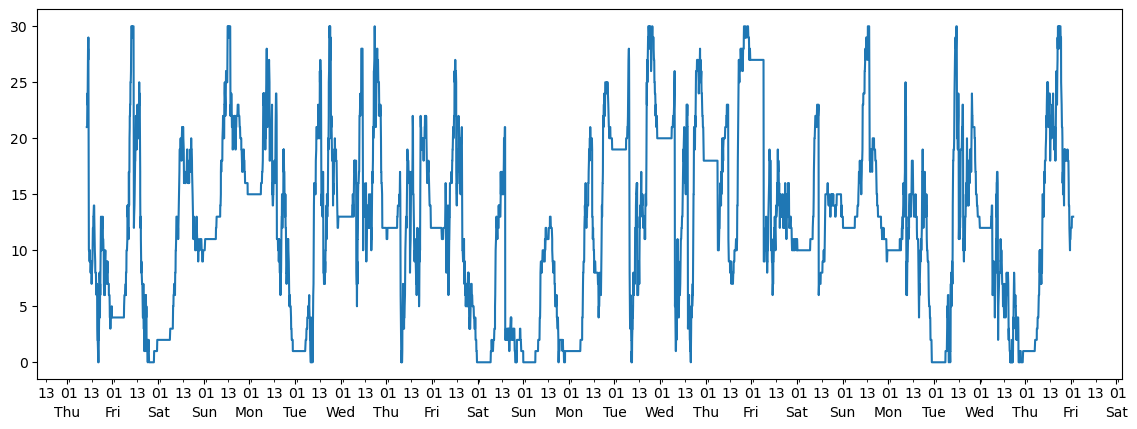

In [11]:
plt.figure().set_figwidth(14)
plt.plot(avail_pearse_df.head(4000)['last_update'], avail_pearse_df.head(4000)['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

The above chart demonstrates the cyclic nature of our dataset.

In [12]:
metadataWH = sqla.MetaData()
# creating table object for weather_historical table
weather_historical = sqla.Table("weather_historical", metadataWH,
                                autoload_with=engine,
                                schema='dbikes'
                                )

2023-04-19 11:58:53,597 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `dbikes`.`weather_historical`
2023-04-19 11:58:53,598 INFO sqlalchemy.engine.Engine [raw sql] ()


We read the weather_historical table into a dataframe:

In [14]:
with engine.begin() as connection:
    wh_df = pd.read_sql_table('weather_historical', connection)

2023-04-19 11:59:22,909 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-19 11:59:22,915 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %s AND table_name = %s
2023-04-19 11:59:22,917 INFO sqlalchemy.engine.Engine [cached since 243.7s ago] ('dbikes', 'weather_historical')
2023-04-19 11:59:23,015 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `weather_historical`
2023-04-19 11:59:23,015 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-19 11:59:23,114 INFO sqlalchemy.engine.Engine SELECT weather_historical.time, weather_historical.temp, weather_historical.wind_dir, weather_historical.wind_speed, weather_historical.wind_gust, weather_historical.global_rad, weather_historical.humidity, weather_historical.pressure, weather_historical.cloudiness, weather_historical.low_clouds, weather_historical.med_clouds, weather_historical.high_clouds, weather_historical.dew_temp, weather_historical.rain, weather_historical.rain_min, weather_histo

Summary statistics for the weather_historical table:

In [15]:
# read csv file for historical wheater table into pandas dataframe, use parse_dates to convert times to format python likes
#wh_df = pd.read_csv("DB_Backup/weather_historical_202304032124.csv")
#wh_df = pd.read_csv("DB_Backup/weather_historical_202304060936.csv")
#wh_df['time'] = pd.to_datetime(wh_df['time'],  format='%Y/%m/%d %H:%M')
wh_df.describe()

,temp,wind_dir,wind_speed,wind_gust,global_rad,humidity,pressure,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,8.502199,180.562378,4.171906,9.378339,110.389577,75.467671,1009.696417,77.488436,52.811482,30.550081,50.574511,4.174349,0.100651,0.071091,0.170765,13.961564
std,3.228142,90.318805,2.121578,4.155799,164.902386,11.207116,15.236452,34.422868,40.875844,41.352347,45.416419,3.899441,0.275781,0.215843,0.362303,25.592474
min,0.700000,0.300000,0.100000,1.500000,0.000000,30.300000,977.200000,0.000000,0.000000,0.000000,0.000000,-11.300000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,102.475000,2.600000,6.400000,0.000000,69.500000,997.775000,63.700000,5.275000,0.000000,0.000000,1.700000,0.000000,0.000000,0.000000,0.000000
50%,8.700000,199.600000,3.900000,8.800000,6.750000,77.050000,1008.400000,99.300000,55.700000,0.200000,56.100000,4.400000,0.000000,0.000000,0.000000,0.900000
75%,11.000000,256.650000,5.500000,12.200000,184.700000,84.100000,1022.500000,100.000000,98.425000,75.325000,99.500000,7.500000,0.000000,0.000000,0.200000,12.825000
max,17.200000,359.500000,12.200000,23.500000,759.700000,96.800000,1039.400000,100.000000,100.000000,100.000000,100.000000,13.300000,2.800000,2.500000,3.000000,100.000000


We create a temporary column in our availabilty table to allow joing with the weather table. This column round the time in the last update column up to the nearest hour, giving the correct time for weather data.

In [16]:
avail_pearse_df['time'] = avail_pearse_df['last_update'].dt.ceil('H')

C:\Users\danor\AppData\Local\Temp\ipykernel_9028\1404984998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avail_pearse_df['time'] = avail_pearse_df['last_update'].dt.ceil('H')


Merging the availability and weather dataframes:

In [17]:
merged_df = pd.merge(
    avail_pearse_df,
    wh_df,
    how='right',
    on='time'
)

Summary statistics for the merged dataframe:

In [18]:
merged_df.head()

,number,available_bikes,available_bike_stands,status,last_update,time,temp,wind_dir,wind_speed,wind_gust,...,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob,symbol
0,32.0,28.0,2.0,OPEN,2023-02-23 11:08:17,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
1,32.0,27.0,3.0,OPEN,2023-02-23 11:12:19,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
2,32.0,29.0,1.0,OPEN,2023-02-23 11:19:23,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
3,32.0,20.0,10.0,OPEN,2023-02-23 11:26:30,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None
4,32.0,11.0,19.0,OPEN,2023-02-23 11:31:52,2023-02-23 12:00:00,8.4,0.8,3.1,7.4,...,0.7,0.7,0.0,0.0,-0.3,0.0,0.0,0.0,0.0,None


We remove data before 23 Feb as it is sparse and discontinuous:

In [19]:
merged_df = merged_df[merged_df['last_update'] >= '2023-02-27']

In [20]:
merged_df.head()

,number,available_bikes,available_bike_stands,status,last_update,time,temp,wind_dir,wind_speed,wind_gust,...,cloudiness,low_clouds,med_clouds,high_clouds,dew_temp,rain,rain_min,rain_max,rain_prob,symbol
30,32.0,21.0,6.0,OPEN,2023-02-27 11:06:42,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
31,32.0,21.0,6.0,OPEN,2023-02-27 11:16:48,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
32,32.0,21.0,6.0,OPEN,2023-02-27 11:26:54,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
33,32.0,21.0,6.0,OPEN,2023-02-27 11:37:00,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None
34,32.0,22.0,5.0,OPEN,2023-02-27 11:46:14,2023-02-27 12:00:00,7.0,96.7,4.3,9.3,...,99.5,99.5,0.0,0.0,0.4,0.0,0.0,0.0,0.0,None


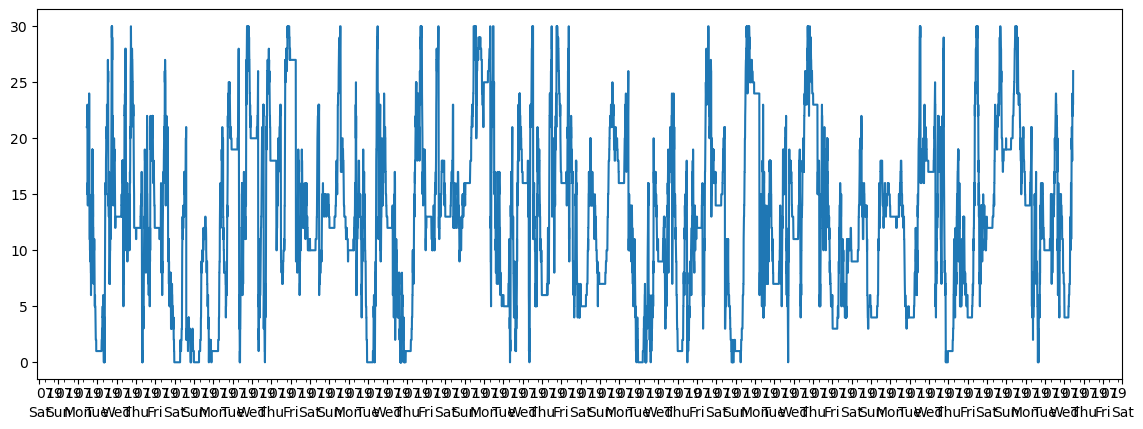

In [21]:
plt.figure().set_figwidth(14)
plt.plot(merged_df['last_update'], merged_df['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

The above chart shows availability over time for the Pearse street station.

We choose to drop the below columns as they are unlikely to be very predicitive, or are represented by remaining columns:

In [22]:
drop_cols = ['wind_dir', 'global_rad', 'humidity', 'pressure', 'cloudiness', 'low_clouds', 'med_clouds', 'high_clouds',
            'dew_temp', 'rain_min', 'rain_max', 'symbol', 'available_bike_stands', 'rain_prob', 'time']
merged_df =  merged_df.drop(drop_cols, axis=1)

In [23]:
merged_df.head()

,number,available_bikes,status,last_update,temp,wind_speed,wind_gust,rain
30,32.0,21.0,OPEN,2023-02-27 11:06:42,7.0,4.3,9.3,0.0
31,32.0,21.0,OPEN,2023-02-27 11:16:48,7.0,4.3,9.3,0.0
32,32.0,21.0,OPEN,2023-02-27 11:26:54,7.0,4.3,9.3,0.0
33,32.0,21.0,OPEN,2023-02-27 11:37:00,7.0,4.3,9.3,0.0
34,32.0,22.0,OPEN,2023-02-27 11:46:14,7.0,4.3,9.3,0.0


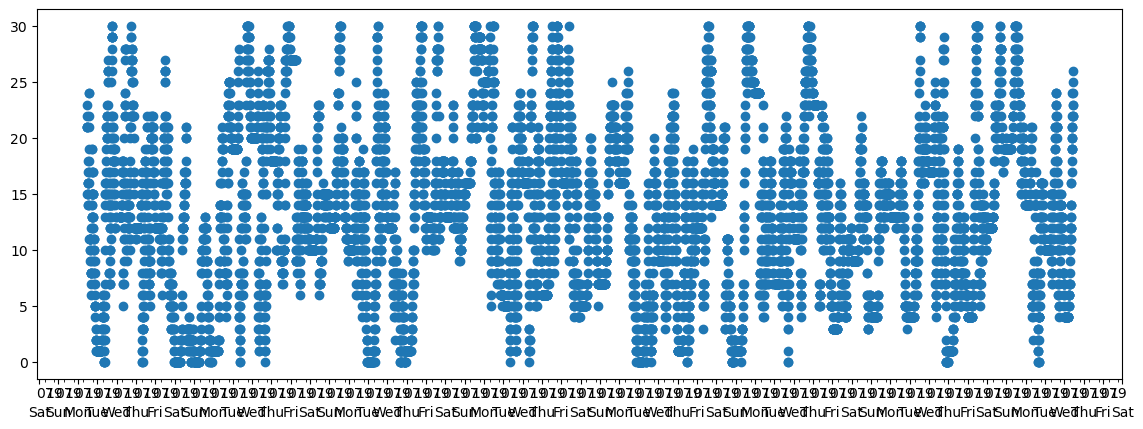

In [24]:
plt.figure().set_figwidth(14)
plt.scatter(merged_df['last_update'], merged_df['available_bikes'])
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

The above chart again shows the availability over time for the Pearse street station, but this time using a scatter plot instead of a line graph.

In [25]:
# we create a weekday column
merged_df['weekday'] = merged_df['last_update'].dt.weekday

In [26]:
merged_df['weekday']

30      0
31      0
32      0
33      0
34      0
       ..
9620    2
9621    2
9622    2
9623    2
9624    2
Name: weekday, Length: 9589, dtype: int64

In [28]:
# we create a workday column that specifies True for a workday, False otherwise
merged_df['workday'] = merged_df['weekday'] < 5

In [29]:
merged_df.to_csv('merged.csv', index=False)

In [30]:
merged_df.head()

,number,available_bikes,status,last_update,temp,wind_speed,wind_gust,rain,weekday,workday
30,32.0,21.0,OPEN,2023-02-27 11:06:42,7.0,4.3,9.3,0.0,0,True
31,32.0,21.0,OPEN,2023-02-27 11:16:48,7.0,4.3,9.3,0.0,0,True
32,32.0,21.0,OPEN,2023-02-27 11:26:54,7.0,4.3,9.3,0.0,0,True
33,32.0,21.0,OPEN,2023-02-27 11:37:00,7.0,4.3,9.3,0.0,0,True
34,32.0,22.0,OPEN,2023-02-27 11:46:14,7.0,4.3,9.3,0.0,0,True


In [31]:
merged_df['last_update']

30     2023-02-27 11:06:42
31     2023-02-27 11:16:48
32     2023-02-27 11:26:54
33     2023-02-27 11:37:00
34     2023-02-27 11:46:14
               ...        
9620   2023-04-19 10:33:58
9621   2023-04-19 10:39:28
9622   2023-04-19 10:44:07
9623   2023-04-19 10:49:49
9624   2023-04-19 10:52:50
Name: last_update, Length: 9589, dtype: datetime64[ns]

In [32]:
# seperate datime into month, day, hour, minute
merged_df['month'] = merged_df['last_update'].dt.month
merged_df['day'] = merged_df['last_update'].dt.day
merged_df['hour'] = merged_df['last_update'].dt.hour
merged_df['minute'] = merged_df['last_update'].dt.minute

In [33]:
# encode workday columns as 0 or 1
#workday = merged_df.workday
#workday = workday.apply(lambda x : 1 if x else 0)
#workday.value_counts()

In [34]:
merged_df.to_csv('merged.csv', index=False)

## Model Creation

In [35]:
features = merged_df

We create a features dataframe to train the model on:

In [36]:
features = features.drop(['number', 'available_bikes', 'status', 'last_update'], axis=1)

In [37]:
features.head()

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46


In [38]:
features['workday']

30      True
31      True
32      True
33      True
34      True
        ... 
9620    True
9621    True
9622    True
9623    True
9624    True
Name: workday, Length: 9589, dtype: bool

In [39]:
features.columns = features.columns.astype(str)

In [40]:
features['workday']

30      True
31      True
32      True
33      True
34      True
        ... 
9620    True
9621    True
9622    True
9623    True
9624    True
Name: workday, Length: 9589, dtype: bool

In [42]:
# y is our target feature
y = merged_df.available_bikes

We create 5 splits of our data in order to train and evaluate our model:

In [43]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [44]:
all_splits = list(ts_cv.split(features, y))
train_0, test_0 = all_splits[0]

In [45]:
features.iloc[test_0]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
4623,8.5,7.1,13.3,0.0,4,True,3,24,4,56
4624,8.5,7.1,13.3,0.0,4,True,3,24,5,0
4625,8.6,7.1,13.6,0.0,4,True,3,24,5,10
4626,8.6,7.1,13.6,0.0,4,True,3,24,5,17
4627,8.6,7.1,13.6,0.0,4,True,3,24,5,27
...,...,...,...,...,...,...,...,...,...,...
5619,15.4,6.0,14.3,0.0,2,True,3,29,14,39
5620,15.4,6.0,14.3,0.0,2,True,3,29,14,49
5621,15.4,6.0,14.3,0.0,2,True,3,29,14,52
5622,15.4,6.0,14.3,0.0,2,True,3,29,14,56


In [46]:
features.iloc[train_0]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46
...,...,...,...,...,...,...,...,...,...,...
4570,8.7,9.2,15.2,0.0,3,True,3,23,20,41
4571,8.7,9.2,15.2,0.0,3,True,3,23,20,51
4572,8.7,9.2,15.2,0.0,3,True,3,23,20,57
4573,8.0,9.4,16.6,0.0,3,True,3,23,21,9


In [47]:
train_4, test_4 = all_splits[2]
features.iloc[test_4]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
6625,6.8,0.6,3.0,0.0,1,True,4,4,2,57
6626,7.3,1.2,3.1,0.0,1,True,4,4,3,7
6627,7.3,1.2,3.1,0.0,1,True,4,4,3,17
6628,7.3,1.2,3.1,0.0,1,True,4,4,3,28
6629,7.3,1.2,3.1,0.0,1,True,4,4,3,38
...,...,...,...,...,...,...,...,...,...,...
7620,8.4,4.8,9.9,0.0,6,False,4,9,1,37
7621,8.4,4.8,9.9,0.0,6,False,4,9,1,47
7622,8.4,4.8,9.9,0.0,6,False,4,9,1,57
7623,8.5,5.1,10.2,0.0,6,False,4,9,2,8


In [48]:
features.iloc[train_4]

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
30,7.0,4.3,9.3,0.0,0,True,2,27,11,6
31,7.0,4.3,9.3,0.0,0,True,2,27,11,16
32,7.0,4.3,9.3,0.0,0,True,2,27,11,26
33,7.0,4.3,9.3,0.0,0,True,2,27,11,37
34,7.0,4.3,9.3,0.0,0,True,2,27,11,46
...,...,...,...,...,...,...,...,...,...,...
6571,9.1,2.9,7.5,0.0,0,True,4,3,18,2
6572,9.1,2.9,7.5,0.0,0,True,4,3,18,8
6573,9.1,2.9,7.5,0.0,0,True,4,3,18,17
6574,9.1,2.9,7.5,0.0,0,True,4,3,18,24


We specify the categoricla columns in our features dataset that are to be encoded:

In [50]:
cat_cols = ['workday']
categories = [
    [False, True]
]
ordinal_encoder = OrdinalEncoder(categories=categories)

Creating the pipeline for our model:

In [51]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, cat_cols),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=cat_cols,
    ),
).set_output(transform="pandas")

Evaluating the model:

In [52]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [53]:
evaluate(gbrt_pipeline, features, y, cv=ts_cv)

Mean Absolute Error:     6.304 +/- 0.506
Root Mean Squared Error: 7.910 +/- 0.664


We fit the model on one of the splits we created earlier in order to create a close-up graph showing how the model performs.

In [54]:
gbrt_pipeline.fit(features.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(features.iloc[test_0])

In [55]:
gbrt_pipeline.fit(features, y)
gbrt_predictions = gbrt_pipeline.predict(features.iloc[test_0])

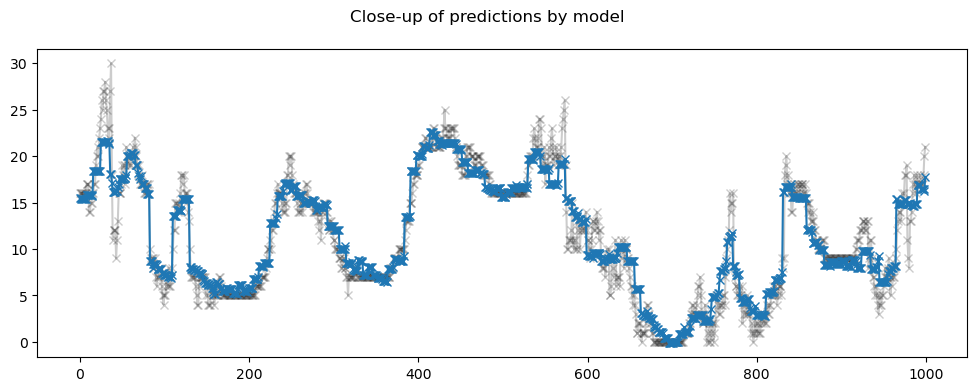

In [56]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Close-up of predictions by model")
ax.plot(
    y.iloc[test_0].values,
    "x-",
    alpha=0.2,
    color="black",
)
ax.plot(
    gbrt_predictions,
    "x-",
)

In the above graph the blue line represents the predictions made by our model and the black lines represent the actual values.

We can see that the model performs quite well.

Next we fit our model to the entire dataset in order to create a see how it performs across the entire dataset:

In [59]:
gbrt_predictions = gbrt_pipeline.predict(features)

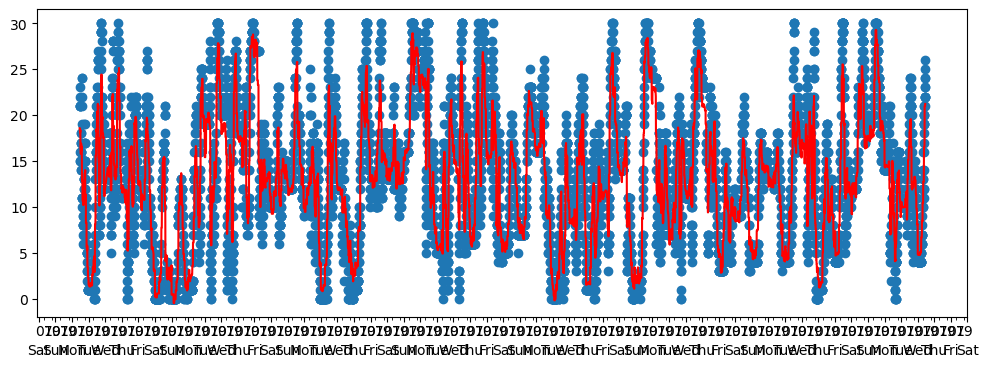

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(merged_df['last_update'], merged_df['available_bikes'])
ax.plot(merged_df['last_update'], gbrt_predictions, "r-", label="Gradient Boosted Trees")
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('\n%a'))
plt.show()

We can see that the model performs good overall, although it does struggle to predict spikes or throughs in demand.

The below code demonstrates how to predict a single value:

In [61]:
test_prediction = features.tail(1)

In [62]:
test_prediction.head()

,temp,wind_speed,wind_gust,rain,weekday,workday,month,day,hour,minute
9624,9.6,6.3,12.8,0.0,2,True,4,19,10,52


In [63]:
test_prediction_result = gbrt_pipeline.predict(test_prediction)

In [64]:
print(test_prediction_result)

[21.20692257]


In [65]:
d = {
    'temp': [8],
    'wind_speed': [2],
    'wind_gust': [6],
    'rain': [0],
    'weekday': [3],
    'workday': [True],
    'month': [5],
    'day': [2],
    'hour': [23],
    'minute': [0]
}
test_prediction = pd.DataFrame(data=d)

In [66]:
test_prediction['temp'].values[0]

8

In [67]:
test_prediction_result = gbrt_pipeline.predict(test_prediction)
print(test_prediction_result)

[13.89478609]


In [68]:
number = merged_df['number'].values[0]
number

32.0

In [77]:
with open(f"pickle_jar/{number}_model.pkl", 'wb') as handle:
    pickle.dump(gbrt_pipeline, handle, pickle.HIGHEST_PROTOCOL)